In [1]:
import pandas as pd
import geopy as gp
import seaborn as sns
import numpy as np
from geopy.distance import distance
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
# center_of_new_york = (40.763889, -73.98)
center_of_new_york = (40.694302, -73.930499)

In [3]:
#Создадим новый признак являющийся расстоянием от квартиры до центра города
#distance((row['latitude'], row['longitude']), center_of_new_york).km

data['center_distance'] = data[['latitude', 'longitude']].apply(
    lambda row: round(((row['latitude'] - center_of_new_york[0])**2 + (row['longitude'] - center_of_new_york[1])**2)**0.5, 2), axis=1)

In [4]:
#Удалим не нужные признаки
data = data.drop(['id', 'name', 'host_id', 'host_name', 'last_review','latitude','longitude', 'reviews_per_month', 'neighbourhood'], axis=1)

In [5]:
data.head()


,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,center_distance
0,Brooklyn,Private room,149,1,9,6,365,0.06
1,Manhattan,Entire home/apt,225,1,45,2,355,0.08
2,Manhattan,Private room,150,3,0,1,365,0.12
3,Brooklyn,Entire home/apt,89,1,270,1,194,0.03
4,Manhattan,Entire home/apt,80,10,9,1,0,0.11


In [6]:
#посмотрим есть ли пропуски
data.isnull().sum()

neighbourhood_group               0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
center_distance                   0
dtype: int64

In [7]:
data.isna().sum()

neighbourhood_group               0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
center_distance                   0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 8 columns):
neighbourhood_group               48895 non-null object
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
center_distance                   48895 non-null float64
dtypes: float64(1), int64(5), object(2)
memory usage: 3.0+ MB


In [9]:
data.describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,center_distance
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,7.143982,112.781327,0.070811
std,240.154170,20.510550,44.550582,32.952519,131.622289,0.042017
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,69.000000,1.000000,1.000000,1.000000,0.000000,0.040000
50%,106.000000,3.000000,5.000000,1.000000,45.000000,0.070000
75%,175.000000,5.000000,24.000000,2.000000,227.000000,0.090000
max,10000.000000,1250.000000,629.000000,327.000000,365.000000,0.370000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95b3665320>,
      dtype=object)

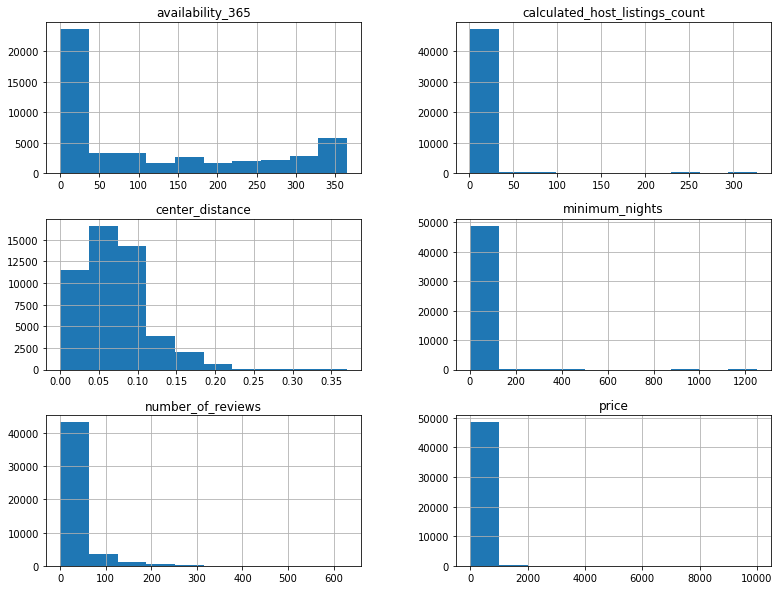

In [10]:
data.hist(figsize=(13,10))

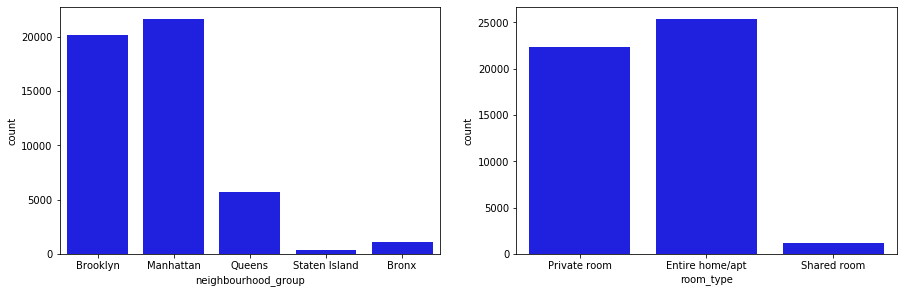

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.countplot(data.neighbourhood_group, color='blue')
plt.subplot(2,2,2)
sns.countplot(data.room_type,color='blue')

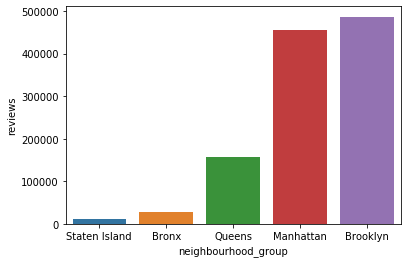

In [12]:
reviews_count=data.groupby('neighbourhood_group')['number_of_reviews'].sum().sort_values()
plt.ylabel('reviews')
plt.xlabel('neighbourhood_group')
sns.barplot(x=reviews_count.index.values, y=reviews_count.values)

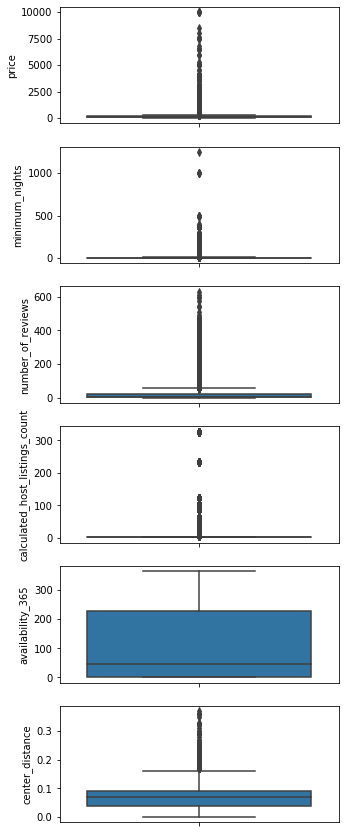

In [13]:
# посмотрим на выбросы

columns = data.drop(['neighbourhood_group', 'room_type'], axis=1).columns
fig, axes = plt.subplots(len(columns),1,figsize=(5,15))

for ax_i, column in enumerate(columns):
    sns.boxplot(y=column, data=data, ax=axes[ax_i])

In [14]:
# попробуем обрезать выбросы, значения возмем на гляз с гистограмм выше.
data = data[(data.price > 0) & (data.price < 600)]
# data = data[data.calculated_host_listings_count < 20]
# data = data[data.center_distance < 25]
# data = data[data.minimum_nights < 60]
# data = data[data.number_of_reviews < 100]

In [15]:
# преобразуем категориальные признаки
data_dummies = pd.get_dummies(data.neighbourhood_group, prefix='area', drop_first=True)
data = pd.concat([data.drop(['neighbourhood_group'], axis=1), data_dummies], axis=1)
data_dummies = pd.get_dummies(data.room_type, prefix='room_type', drop_first=True)
data = pd.concat([data.drop(['room_type'], axis=1), data_dummies], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95b2a60b70>,
      dtype=object)

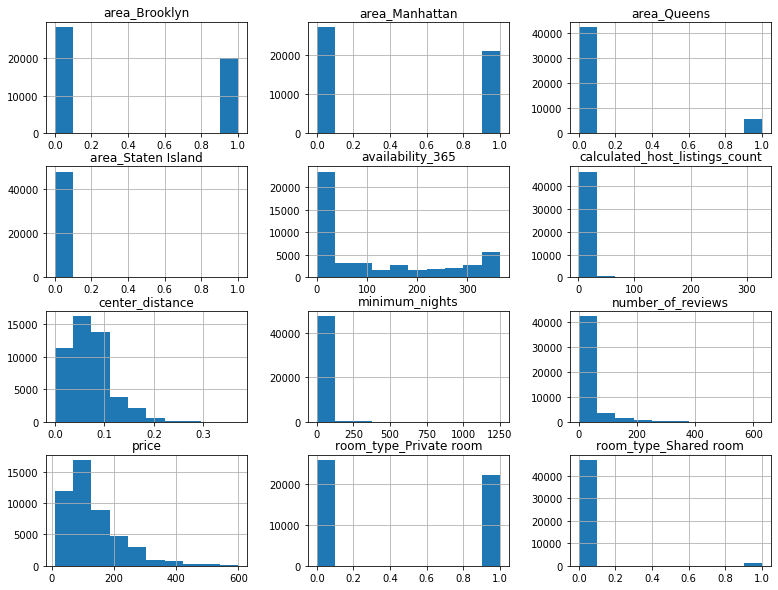

In [16]:
data.hist(figsize=(13,10))

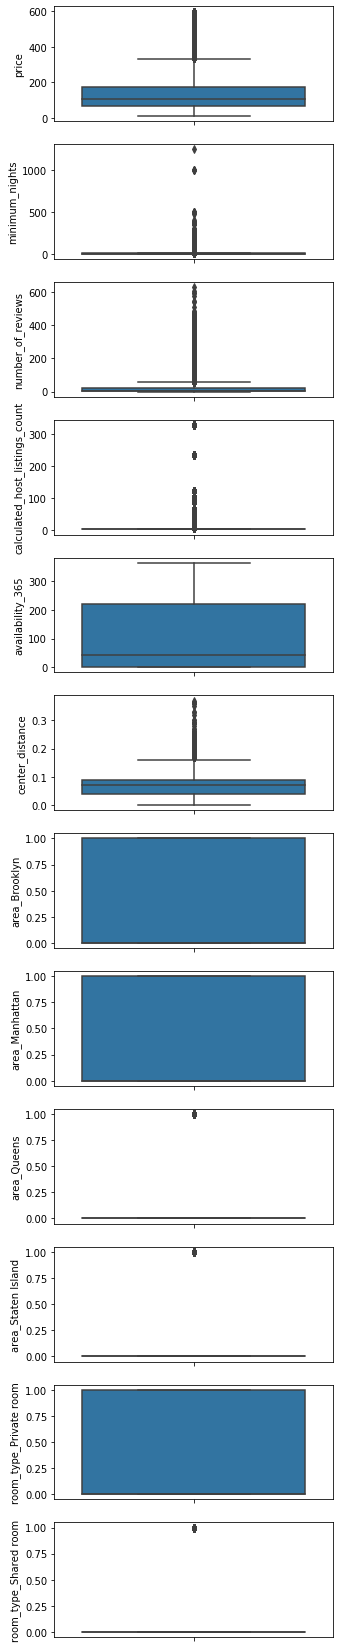

In [17]:
columns = data.columns
fig, axes = plt.subplots(len(columns),1,figsize=(5,30))

for ax_i, column in enumerate(columns):
    sns.boxplot(y=column, data=data, ax=axes[ax_i])

Посмотрим коррелции в данных

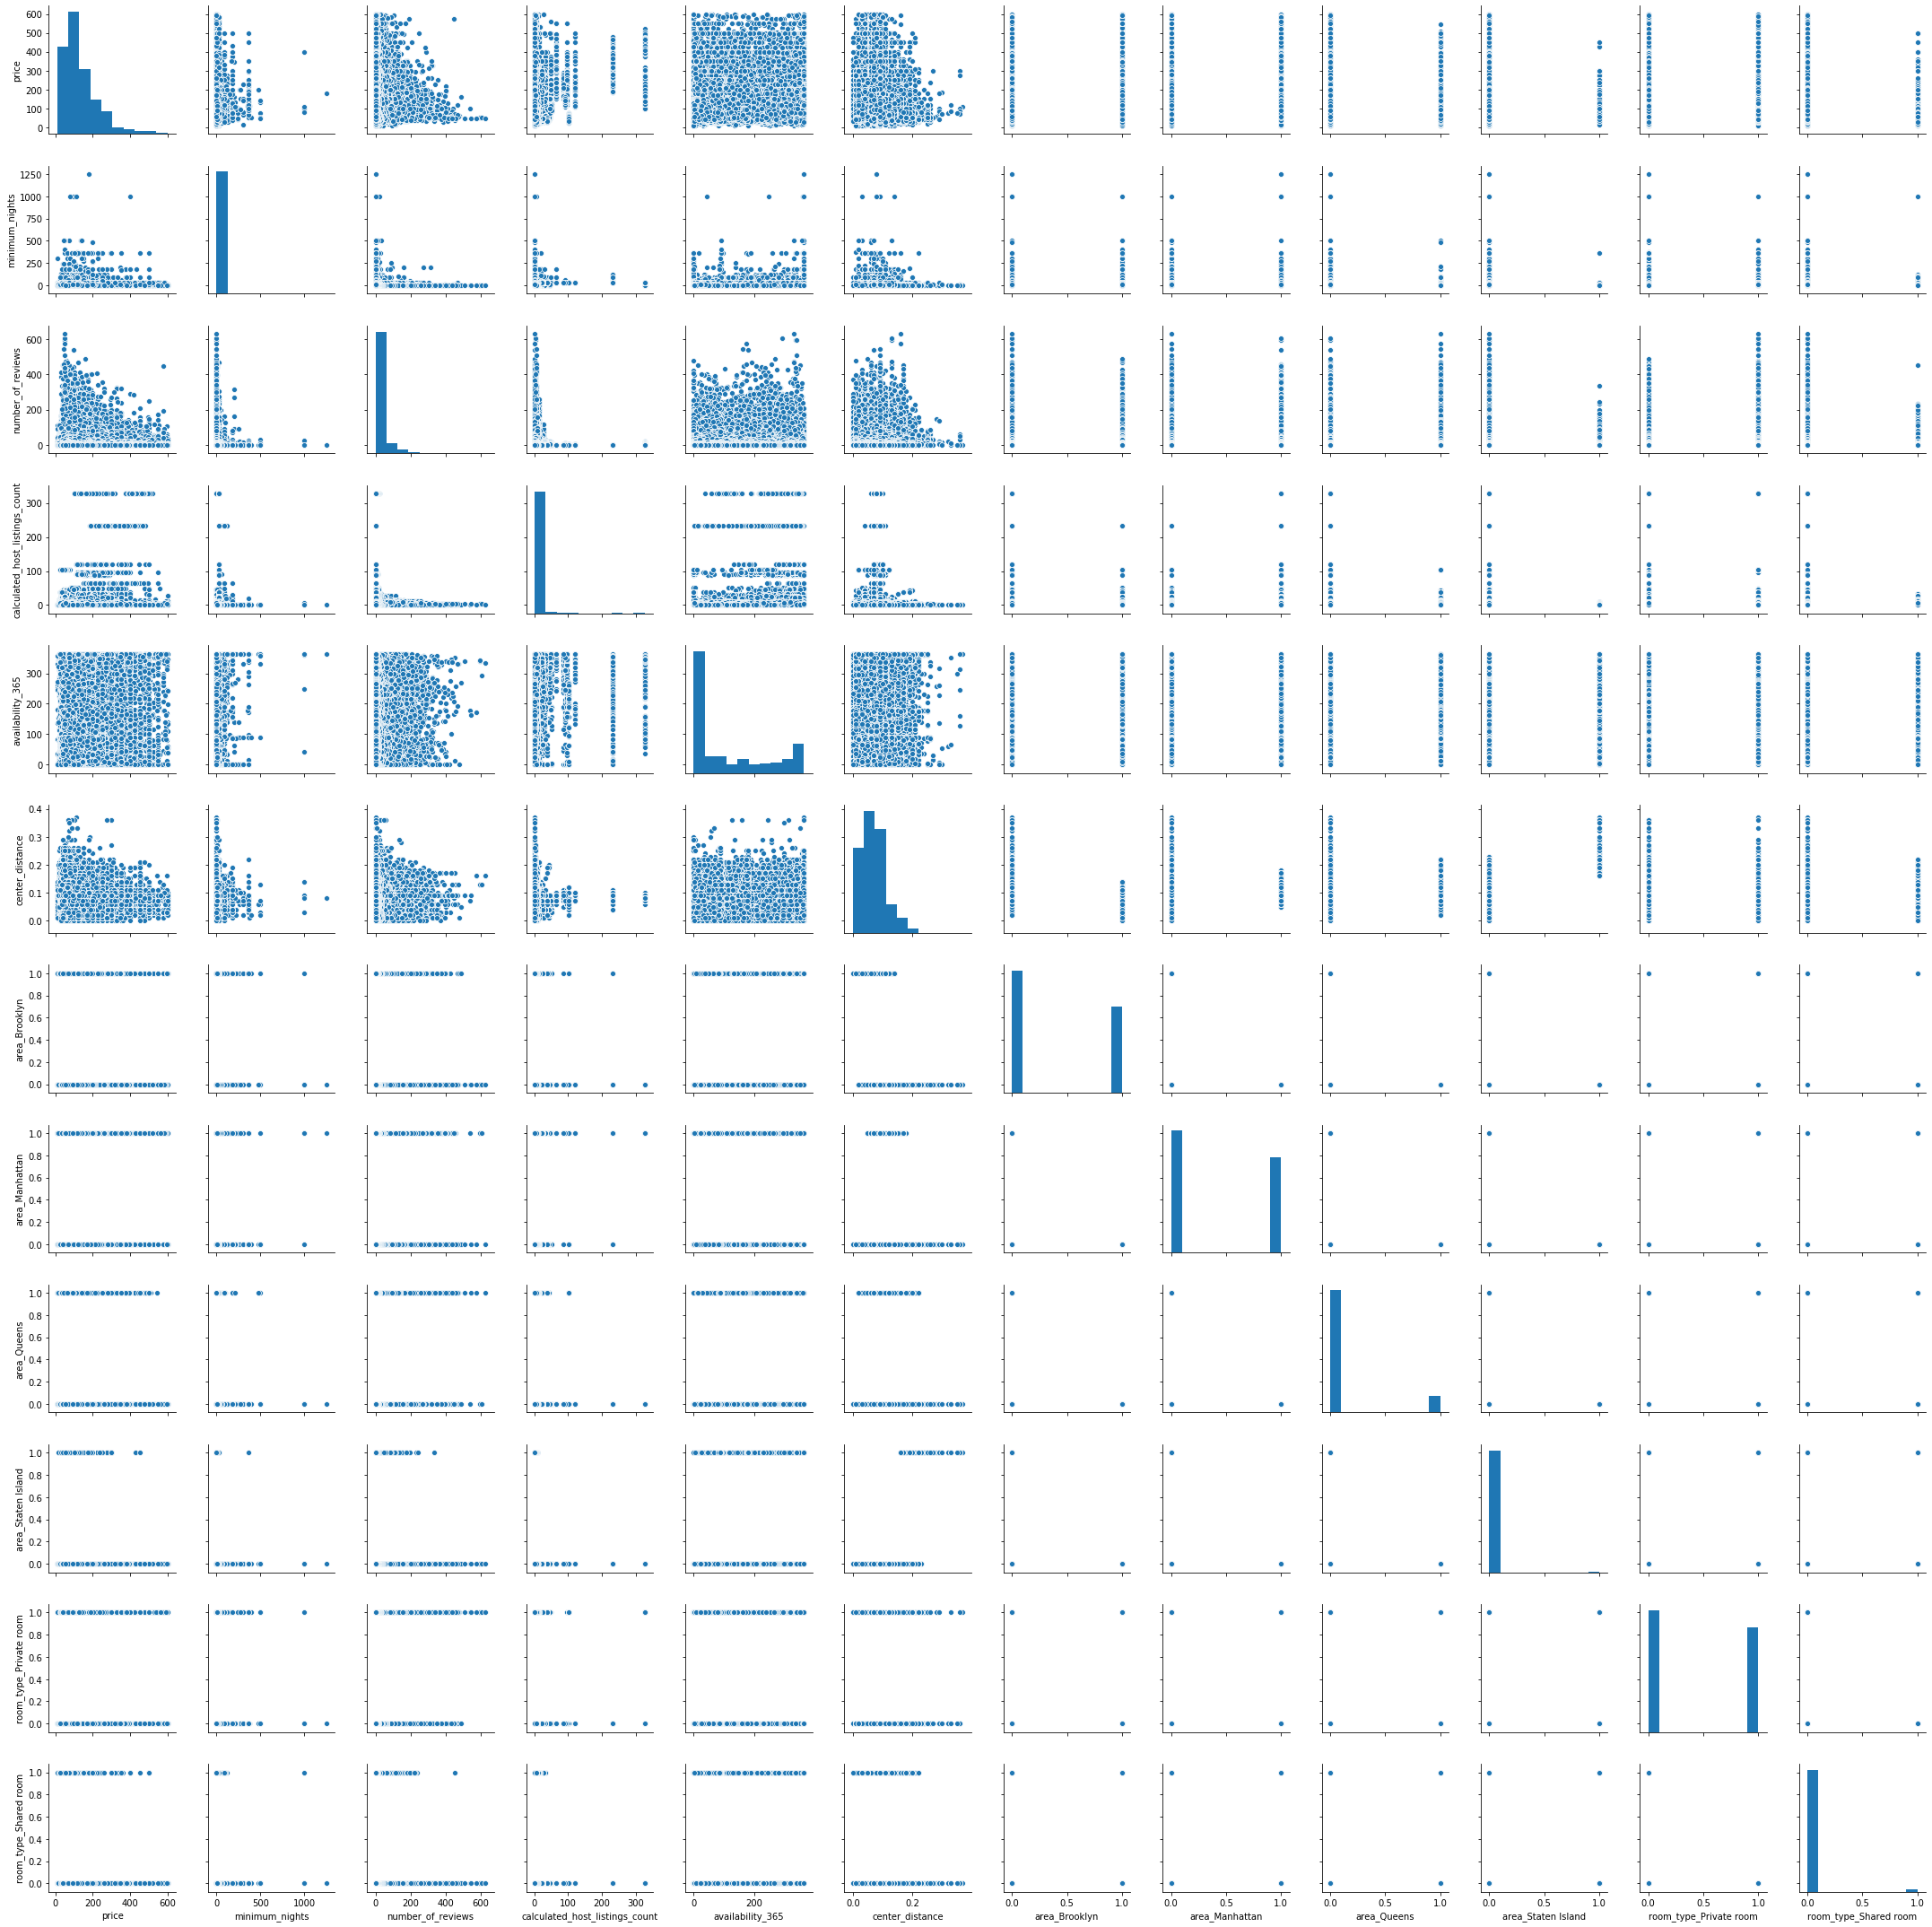

In [18]:
sns.pairplot(data)

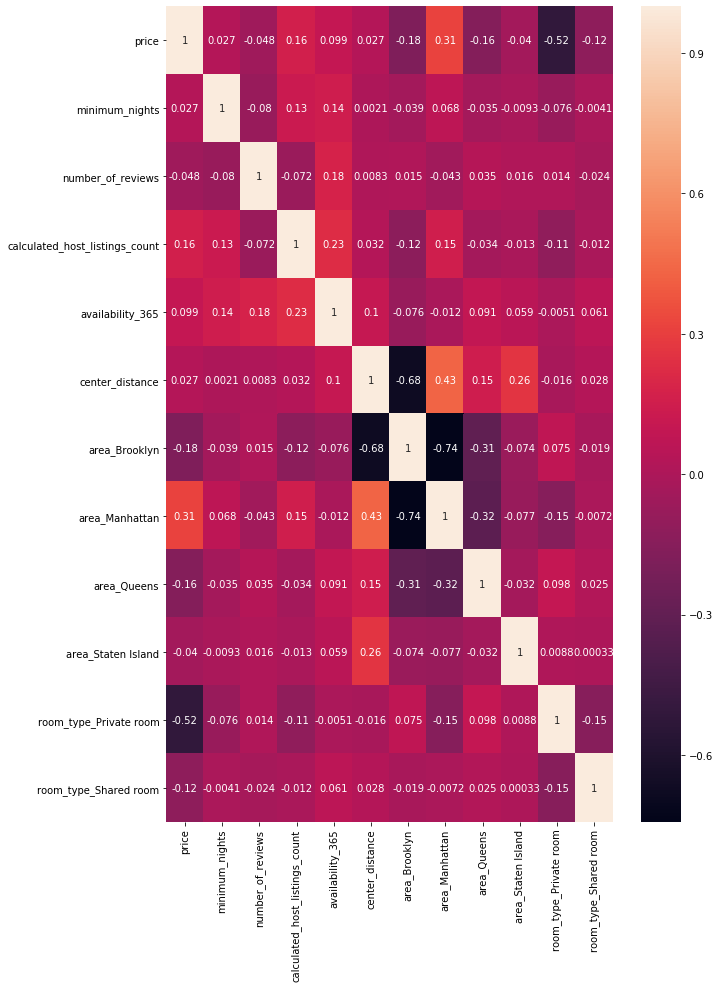

In [19]:
plt.figure(figsize=(10,15))
sns.heatmap(data.corr(), annot=True)

разделим выборку для обучения, теста и проскалируем

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.3)

In [21]:
from sklearn.preprocessing import StandardScaler

scale_columns = ['minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365','center_distance']
scaler = StandardScaler()
scaler.fit(data_train[scale_columns])
data_train_scale = scaler.transform(data_train[scale_columns])
data_test_scale = scaler.transform(data_test[scale_columns])
data_train[scale_columns] = data_train_scale
data_test[scale_columns] = data_test_scale

In [22]:
y_train=data_train.price
y_test=data_test.price
X_train=data_train.drop('price', axis=1).get_values()
X_test=data_test.drop('price', axis=1).get_values()

In [23]:
from sklearn import metrics

def get_feature_importance_bar(data, model):
    feature_importance = pd.DataFrame({
        'feature': data.columns,
        'importance': model.coef_
    })
    
    feature_importance.set_index('feature', inplace=True)
    feature_importance[feature_importance.importance > 5].sort_values(['importance'], ascending=False, inplace=True)
    return feature_importance.importance.plot('bar')

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

Обучим модель линейной регрессии

In [24]:
from sklearn.linear_model import LinearRegression

model_regression = LinearRegression()
model_regression.fit(X_train, y_train)
y_pred_regr = model_regression.predict(X_test)

MAE: 47.928697718081374
RMSE: 70.85140750323028
R2: 0.3867175104060462
MAPE: 42.79938265576992


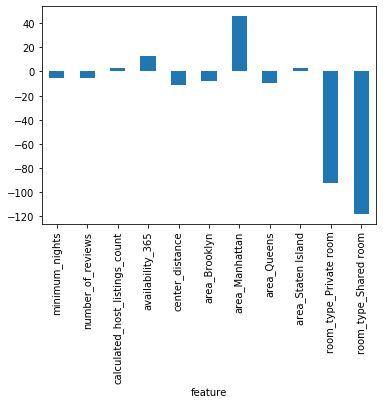

In [25]:
print_metrics(y_test, y_pred_regr)
get_feature_importance_bar(data.drop('price', axis=1), model_regression)

обучим модель ленейной регресси с lasso

In [26]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print(f"Лучшее значение параметра alpha: {lasso_cv.alpha_}")
y_pred_lasso_cv = lasso_cv.predict(X_test)
print_metrics(y_test, y_pred_lasso_cv)

Лучшее значение параметра alpha: 0.023628427676451513
MAE: 47.91881765655504
RMSE: 70.84908523542693
R2: 0.3867577123692765
MAPE: 42.81063904439342


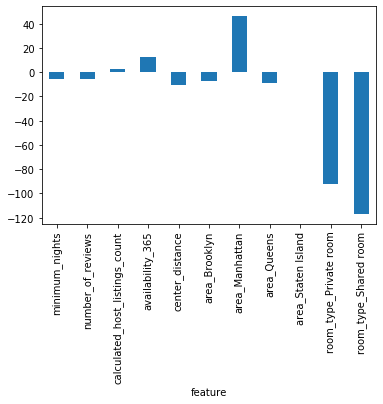

In [27]:
get_feature_importance_bar(data.drop('price', axis=1), lasso_cv)

In [28]:
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train, y_train)
print(f"Лучшее значение параметра alpha: {lasso_cv.alpha_}")
y_pred_ridge_cv = ridge_cv.predict(X_test)
print_metrics(y_test, y_pred_ridge_cv)

Лучшее значение параметра alpha: 0.023628427676451513
MAE: 47.928503699893284
RMSE: 70.85129175048166
R2: 0.3867195142921611
MAPE: 42.80253546972162


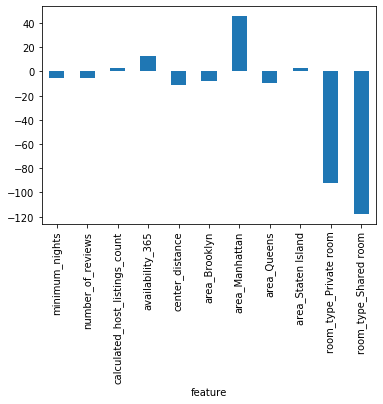

In [29]:
get_feature_importance_bar(data.drop('price', axis=1), ridge_cv)

In [30]:
elastic_net_cv = ElasticNetCV(cv=5)
elastic_net_cv.fit(X_train, y_train)
print(f"Лучшее значение параметра alpha: {elastic_net_cv.alpha_}")
y_pred_elastic_net_cv = elastic_net_cv.predict(X_test)
print_metrics(y_test, y_pred_elastic_net_cv)

Лучшее значение параметра alpha: 0.047256855352903006
MAE: 48.46118110151638
RMSE: 71.50298797668074
R2: 0.3753856153764652
MAPE: 45.513643186016736


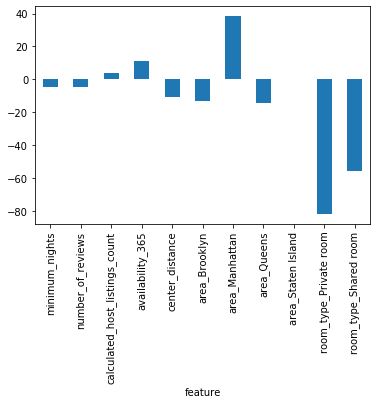

In [31]:
get_feature_importance_bar(data.drop('price', axis=1), elastic_net_cv)

Text(0.5, 0, 'elastic_net_cv')

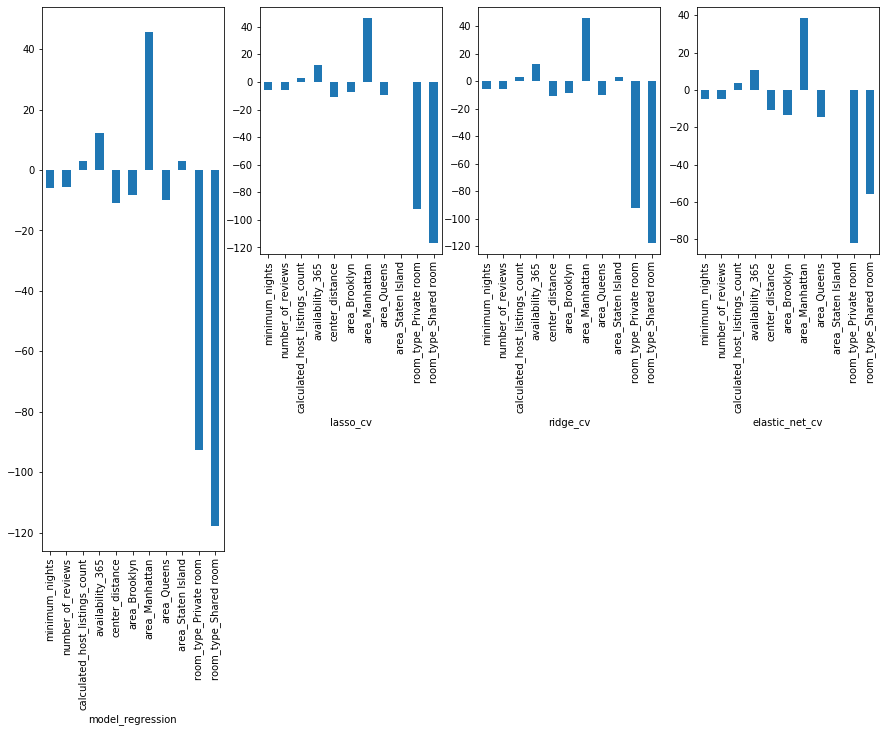

In [36]:
# отобразим важность признаков
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
get_feature_importance_bar(data.drop('price', axis=1), model_regression)
plt.xlabel('model_regression')
plt.subplot(2,4,2)
get_feature_importance_bar(data.drop('price', axis=1), lasso_cv)
plt.xlabel('lasso_cv')
plt.subplot(2,4,3)
get_feature_importance_bar(data.drop('price', axis=1), ridge_cv)
plt.xlabel('ridge_cv')
plt.subplot(2,4,4)
get_feature_importance_bar(data.drop('price', axis=1), elastic_net_cv)
plt.xlabel('elastic_net_cv')